<a href="https://colab.research.google.com/github/rubentea16/Image-Classification-LeNet5-CIFAR10/blob/master/Image%20Classification_LeNet5_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with CIFAR-10 dataset use LeNet-5 Architecture

This notebook want to classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples.

Some of the code and description of this notebook is provided by Udacity's Deep Learning Nanodegree program and from this repo :

https://github.com/deep-diver/CIFAR10-img-classification-tensorflow

This notebook has been reproduced by my self for learn CNN used Tensorflow

## Download the Dataset
Download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

## Import Library

In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the Drive helper and mount
from google.colab import drive
from google.colab import files

# This will prompt for authorization.
drive.mount('/content/drive')

from tqdm import tqdm
tqdm.pandas()
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## List of Data Batch

![](https://miro.medium.com/max/101/1*AyvPEj4ewfyU1TMFWWfj1Q.png)

As seen above picture, the dataset is broken into batches to prevent your machine from running out of memory. The CIFAR-10 dataset consists of 5 batches, named data_batch_1, data_batch_2, etc.

## Understanding the original data
The original a batch data is (10000 x 3072) dimensional tensor expressed in numpy array, where the number of columns, (10000), indicates the number of sample data. 

As stated in the CIFAR-10/CIFAR-100 dataset, the row vector, (3072) represents an color image of 32x32 pixels. Since this project is going to use CNN for the classification tasks, the row vector, (3072), is not an appropriate form of image data to feed. 

In order to feed an image data into a CNN model, the dimension of the tensor representing an image data should be either (width x height x num_channel) or (num_channel x width x height). It depends on your choice (check out the tensorflow conv2d). In this particular project, I am going to use the dimension of the first choice because the default choice in tensorflow's CNN operation is so.


## Understanding the original labels
The label data is just a list of 10000 numbers in the range 0-9, which corresponds to each of the 10 classes in CIFAR-10.

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck


In [0]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Directory Path

In [0]:
data_dir = "drive/My Drive/Colab Notebooks/cnn_cifar10/"

## How to reshape into a such form?

The row vector (3072) has the exact same number of elements if you calculate 32\*32\*3==3072. In order to reshape the row vector, (3072), there are two steps required. The **first** step is involved with using **reshape** function in numpy, and the **second** step is involved with using **transpose** function in numpy as well.

By definition from the official web site, **reshape** function gives a new shape to an array without changing its data. Here, the phrase **without changing its data** is an important part. **reshape** operations should be delivered in three more detailed step. The following direction is described in a logical concept. 

1. divide the row vector (3072) into 3 pieces. Each piece corresponds to the each channels.
  - this results in (3 x 1024) dimension of tensor
2. divide the resulting tensor from the previous step with 32. 32 here means width of an image.
  - this results in (3 x 32 x 32)

In order to implement the directions written in logical sense in numpy, **reshape** function should be called in the following arguments, (10000, 3, 32, 32). As you noticed, reshape function doesn't automatically divide further when the third value (32, width) is provided. We need to explicitly specify the value for the last value (32, height)


This is not the end of story. Now, the image data is represented as (num_channel, width, height) form. However, **this is not the shape tensorflow and matplotlib are expecting**. They are expecting different shape of (width, height, num_channel) instead. We need to swap the order of each axes, and that is where **transpose** function comes in.

The **transpose** function can take a list of axes, and each value specifies where it wants to move around. For example, calling transpose with argument (1, 2, 0) in an numpy array of (num_channel, width, height) will return a new numpy array of (width, height, num_channel).

![alt text](https://github.com/deep-diver/CIFAR10-img-classification-tensorflow/raw/c96a0cbbe91ee280a5de1b3b872e407b0a2c7f34/reshape-transpose.png)

## Reshape data

In [0]:
def load_dataset_batch(dir_path, batch_id):
    with open(dir_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

## Explore the Data

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

The display_stats defined below answers some of questions like in a given batch of data..
- "What are all possible labels?"
- "What is the range of values for the image data?"
- "Are the labels in order or random?"


In [0]:
def display_stats(dir_path, batch_id, sample_id):
    features, labels = load_dataset_batch(dir_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 8888:
Image - Min Value: 0 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


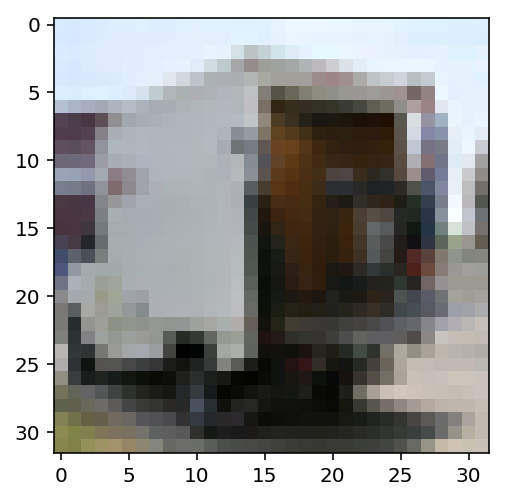

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 8888
display_stats(data_dir, batch_id, sample_id)

# Data Preprocessing and Save it

In [0]:
def normalize(x): # Min-Max Scaler
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [0]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

![alt text](https://github.com/deep-diver/CIFAR10-img-classification-tensorflow/raw/c96a0cbbe91ee280a5de1b3b872e407b0a2c7f34/train-valid-test%20split.png)

In [0]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))

In [0]:
def preprocess_and_save_data(dir_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_dataset_batch(dir_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the labels
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], data_dir+ 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

        
    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels), data_dir+
                         'preprocess_validation.p')

    # load the test dataset
    with open(dir_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels), data_dir+
                         'preprocess_testing.p')

In [0]:
# DO Data Preprocessing and Save it
preprocess_and_save_data(data_dir, normalize, one_hot_encode)

## Checkpoint

In [0]:
valid_features, valid_labels = pickle.load(open(data_dir+'preprocess_validation.p', mode='rb'))

## Prepare Input for the Model

In [0]:
import tensorflow as tf
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Implementation of the LeNet-5 Network

## **Architecture**
**Layer 1: Convolutional**. The output shape should be 28x28x6.

>**Activation**. Your choice of activation function.

>**Pooling**. The output shape should be 14x14x6.

**Layer 2: Convolutional**. The output shape should be 10x10x16.

>**Activation**. Your choice of activation function.

>**Pooling**. The output shape should be 5x5x16.

>**Flatten**. Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using tf.contrib.layers.flatten, which is already imported for you.

**Layer 3: Fully Connected**. This should have 120 outputs.

>**Activation**. Your choice of activation function.

**Layer 4: Fully Connected**. This should have 84 outputs.

>**Activation**. Your choice of activation function.

**Layer 5: Fully Connected**. This should have 10 outputs.

![alt text](https://github.com/sujaybabruwad/LeNet-in-Tensorflow/raw/a2acba7298c774501245f2710470202f7a0d43f5/lenet.png)

In [0]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Filter = [filter_height, filter_width, in_channels, out_channels]
    conv1_filter = tf.Variable(tf.truncated_normal(shape = [5,5,3,6],mean = mu, stddev = sigma))
    conv2_filter = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1 = tf.nn.conv2d(x, conv1_filter, strides = [1,1,1,1], padding = 'VALID')
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_1 = tf.nn.avg_pool(conv1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2 = tf.nn.conv2d(pool_1, conv2_filter, strides = [1,1,1,1], padding = 'VALID')
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.avg_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
    fc1 = tf.matmul(fc1, fc1_w)
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
    fc2 = tf.matmul(fc1, fc2_w)
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    # Dropout
    #fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_w = tf.Variable(tf.truncated_normal(shape = (84,10), mean = mu , stddev = sigma))
    out = tf.matmul(fc2, fc3_w)
    return out
  

### Hyperparameters

* `epochs`: number of iterations until the network stops learning or start overfitting
* `batch_size`: highest number that your machine has memory for.  Most people set them to common sizes of memory:
* `learning_rate`: number how fast the model learns
* `keep_probability`: probability of keeping a node using dropout

In [0]:
epochs = 400
batch_size = 128
learning_rate = 0.002
keep_probability = 0.7

## Lost Function and Optimizer

In [0]:
logits = LeNet(x)
model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Training LeNet-5

### Single Optimization

In [0]:
def train_neural_network(session, optimizer, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                })

### Show Stats

In [0]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

### Fully Train the Model

In [0]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = data_dir + 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [0]:
save_model_path = data_dir + '/image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2893 Validation Accuracy: 0.102400
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.2904 Validation Accuracy: 0.101600
Epoch  1, CIFAR-10 Batch 3:  Loss:     2.2975 Validation Accuracy: 0.102000
Epoch  1, CIFAR-10 Batch 4:  Loss:     2.3013 Validation Accuracy: 0.101800
Epoch  1, CIFAR-10 Batch 5:  Loss:     2.3044 Validation Accuracy: 0.101600
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.2852 Validation Accuracy: 0.102000
Epoch  2, CIFAR-10 Batch 2:  Loss:     2.2900 Validation Accuracy: 0.102000
Epoch  2, CIFAR-10 Batch 3:  Loss:     2.2972 Validation Accuracy: 0.101000
Epoch  2, CIFAR-10 Batch 4:  Loss:     2.2970 Validation Accuracy: 0.107600
Epoch  2, CIFAR-10 Batch 5:  Loss:     2.2986 Validation Accuracy: 0.112600
Epoch  3, CIFAR-10 Batch 1:  Loss:     2.2784 Validation Accuracy: 0.124600
Epoch  3, CIFAR-10 Batch 2:  Loss:     2.2898 Validation Accuracy: 0.132400
Epoch  3, CIFAR-10 Batch 3:  Loss:     2.2961 Validation Accuracy: 0.133600


# Test Model

In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def display_image_predictions(features, labels, predictions, top_n_predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=top_n_predictions, ncols=2, figsize=(20, 10))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
   
    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        if (image_i < top_n_predictions):
            pred_names = [label_names[pred_i] for pred_i in pred_indicies]
            correct_name = label_names[label_id]
            
            axies[image_i][0].imshow((feature*255).astype(np.int32, copy=False))
            axies[image_i][0].set_title(correct_name)
            axies[image_i][0].set_axis_off()

            axies[image_i][1].barh(ind + margin, pred_values[:3], width)
            axies[image_i][1].set_yticks(ind + margin)
            axies[image_i][1].set_yticklabels(pred_names[::-1])
            axies[image_i][1].set_xticks([0, 0.5, 1.0])

2019-09-11 07:10:24,513 : INFO : Restoring parameters from drive/My Drive/Colab Notebooks/cnn_cifar10/image_classification


Testing Accuracy: 0.5711584394904459



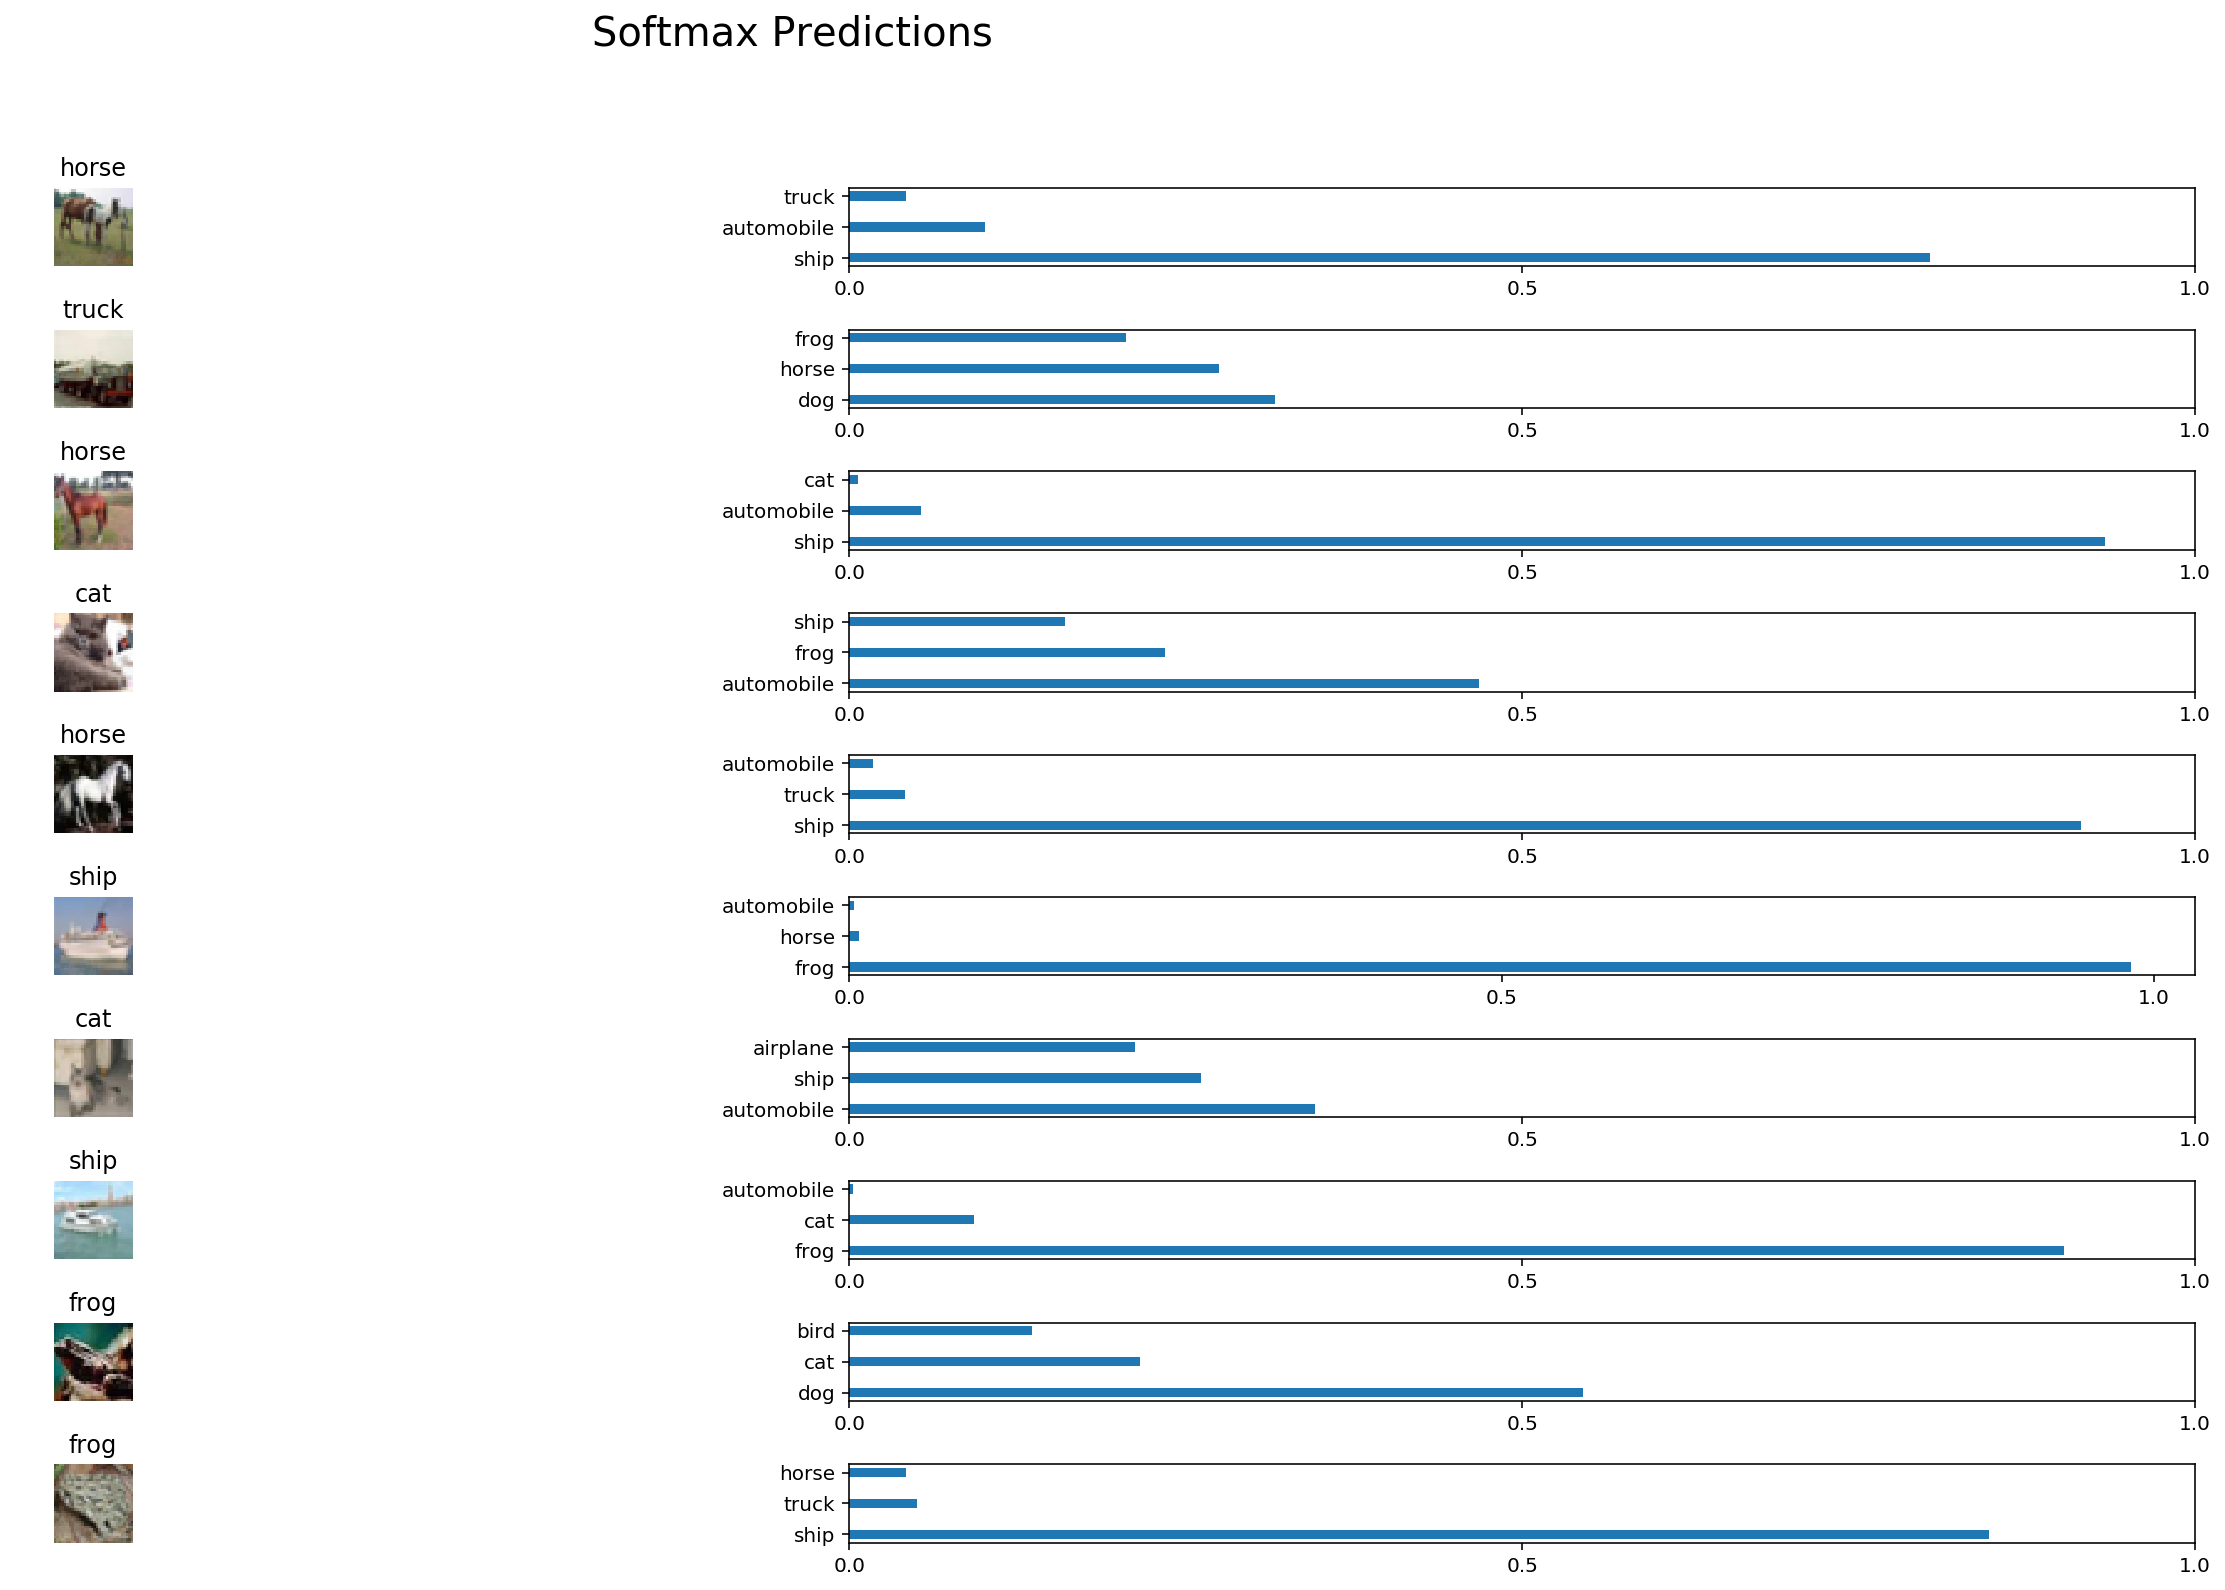

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

save_model_path = data_dir + 'image_classification'
batch_size = 64
n_samples = 500
top_n_predictions = 10

def test_model():
    test_features, test_labels = pickle.load(open(data_dir + 'preprocess_testing.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions, top_n_predictions)


test_model()